In [128]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import einops

from typing import Dict, List, Tuple, Callable
from torch import Tensor
from jaxtyping import Float, Int
from transformer_lens import HookedTransformer

In [2]:
torch.set_grad_enabled(False)

In [3]:
def set_seed(seed: int):
    torch.random.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
model = HookedTransformer.from_pretrained_no_processing('meta-llama/Llama-3.1-8B', device='cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [5]:
class Grid:
    def __init__(self, words, rows, cols):
        n_words = len(words)
        
        if rows * cols != n_words:
            raise ValueError(f"Grid dimensions ({rows}x{cols}={rows*cols}) do not match number of words ({n_words})")

        self.words = words
        self.rows = rows
        self.cols = cols
        self.grid = np.array(words).reshape(self.rows, self.cols).tolist()

        self.word_to_col = {word: i % cols for i, word in enumerate(words)}
        self.word_to_row = {word: i // cols for i, word in enumerate(words)}

    def generate_sequence(self, seq_len):
        sequence = []

        row, col = np.random.randint(0, self.rows), np.random.randint(0, self.cols)
        sequence.append(self.grid[row][col])

        while len(sequence) < seq_len:
            valid_moves = self._get_valid_moves(row, col)

            direction = np.random.choice(valid_moves)
            if direction == 'up':
                row -= 1
            elif direction == 'down':
                row += 1
            elif direction == 'left':
                col -= 1
            elif direction == 'right':
                col += 1

            sequence.append(self.grid[row][col])

        return sequence
    
    def get_valid_next_words(self, word):
        row, col = self.word_to_row[word], self.word_to_col[word]
        return self._get_valid_next_words_from_position(row, col)
    
    def _get_valid_next_words_from_position(self, row, col):
        valid_moves = self._get_valid_moves(row, col)
        next_words = []
        for move in valid_moves:
            if move == 'up':
                next_words.append(self.grid[row-1][col])
            elif move == 'down':
                next_words.append(self.grid[row+1][col])
            elif move == 'left':
                next_words.append(self.grid[row][col-1])
            elif move == 'right':
                next_words.append(self.grid[row][col+1])
        return next_words
    
    def _get_valid_moves(self, row, col):
        valid_moves = []
        if row > 0: valid_moves.append('up')
        if row < self.rows - 1: valid_moves.append('down')
        if col > 0: valid_moves.append('left')
        if col < self.cols - 1: valid_moves.append('right')
        return valid_moves

In [6]:
words = ['apple', 'bird', 'car', 'egg','house', 'milk', 'plane', 'opera', 'box', 'sand', 'sun', 'mango', 'rock', 'math', 'code', 'phone']

## Induction heads

In [44]:
set_seed(0)
random_tokens = torch.randint(low=0, high=model.cfg.d_vocab//2, size=(64,))
random_tokens_repeated = torch.cat([random_tokens] * 2, dim=0)

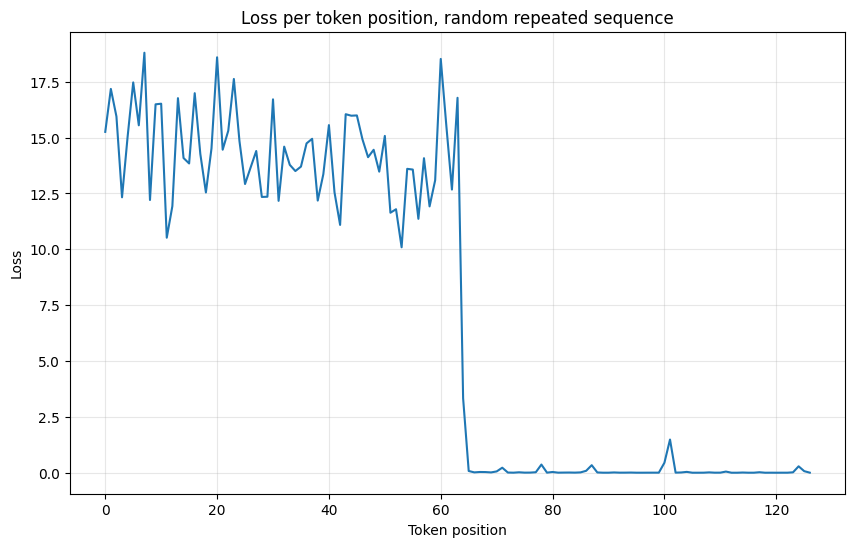

In [45]:
logits = model(random_tokens_repeated.to(model.cfg.device))
log_probs = torch.log_softmax(logits, dim=-1).to('cpu')

loss_per_token = torch.gather(input=-log_probs[0, :-1, :], dim=-1, index=random_tokens_repeated[1:].unsqueeze(-1))

plt.figure(figsize=(10, 6))
plt.plot(loss_per_token.flatten().numpy())
plt.grid(True, alpha=0.3)
plt.xlabel('Token position')
plt.ylabel('Loss')
plt.title('Loss per token position, random repeated sequence')

plt.show()

In [84]:
name_filters = [f'blocks.{layer}.attn.hook_pattern' for layer in range(model.cfg.n_layers)]

_, cache = model.run_with_cache(random_tokens_repeated, names_filter=name_filters)

In [97]:
def induction_head_score(pattern: Float[Tensor, "seq seq"]) -> float:
    seq, _ = pattern.shape
    offset = (seq//2) - 1 # (128//2) - 1 = 63: we want position 63 to be looking back to position 0, in order to move position 0 to position 64

    return pattern.diagonal(offset=-offset).mean()

In [99]:
layer_to_head_to_score = {}
for layer in range(model.cfg.n_layers):
    layer_to_head_to_score[layer] = {}
    for head in range(model.cfg.n_heads):
        pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
        layer_to_head_to_score[layer][head] = induction_head_score(pattern)

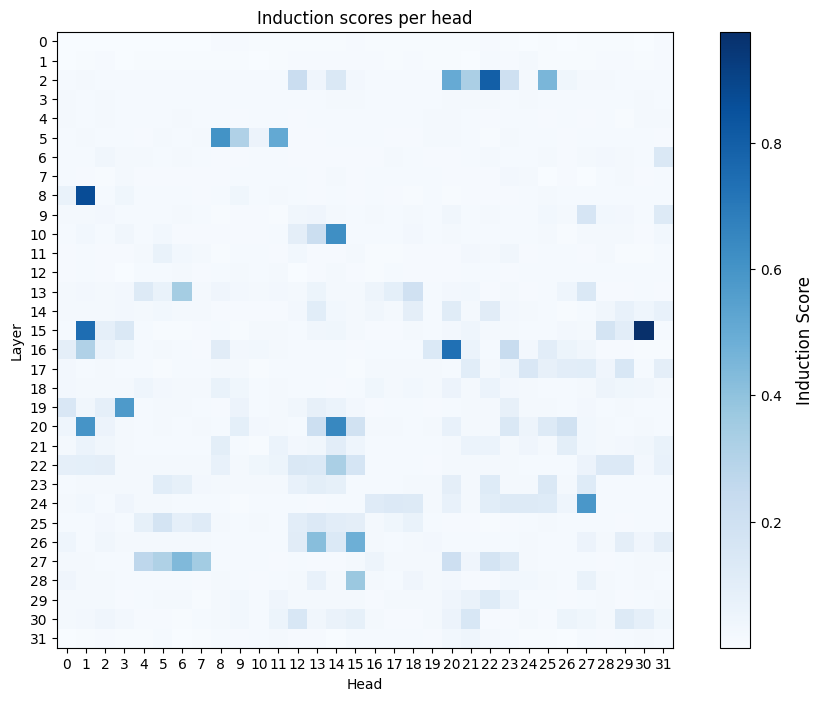

In [102]:
# Convert dictionary to numpy array for plotting
scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        scores[layer, head] = layer_to_head_to_score[layer][head]

plt.figure(figsize=(12, 8))
im = plt.imshow(scores, cmap='Blues')
cbar = plt.colorbar(im)
cbar.set_label('Induction Score', fontsize=12, labelpad=10)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Induction scores per head')
plt.xticks(range(model.cfg.n_heads))
plt.yticks(range(model.cfg.n_layers))
plt.show()

In [108]:
# Create list of (score, layer, head) tuples
induction_scores_as_list = [
    (layer_to_head_to_score[layer][head], layer, head) 
    for layer in range(model.cfg.n_layers) 
    for head in range(model.cfg.n_heads)
]

# Sort by score (first element of tuple)
induction_scores_as_list.sort(key=lambda x: x[0], reverse=True)

k = 20
print(f"Top {k} induction heads:")
for score, layer, head in induction_scores_as_list[:k]:
    print(f"Layer {layer}, Head {head}: {score:.3f}")

Top 20 induction heads:
Layer 15, Head 30: 0.976
Layer 8, Head 1: 0.867
Layer 2, Head 22: 0.798
Layer 15, Head 1: 0.746
Layer 16, Head 20: 0.732
Layer 20, Head 14: 0.648
Layer 10, Head 14: 0.621
Layer 5, Head 8: 0.604
Layer 20, Head 1: 0.597
Layer 24, Head 27: 0.584
Layer 19, Head 3: 0.573
Layer 5, Head 11: 0.511
Layer 2, Head 20: 0.503
Layer 26, Head 15: 0.484
Layer 2, Head 25: 0.452
Layer 27, Head 6: 0.437
Layer 26, Head 13: 0.416
Layer 28, Head 15: 0.372
Layer 27, Head 7: 0.350
Layer 13, Head 6: 0.344


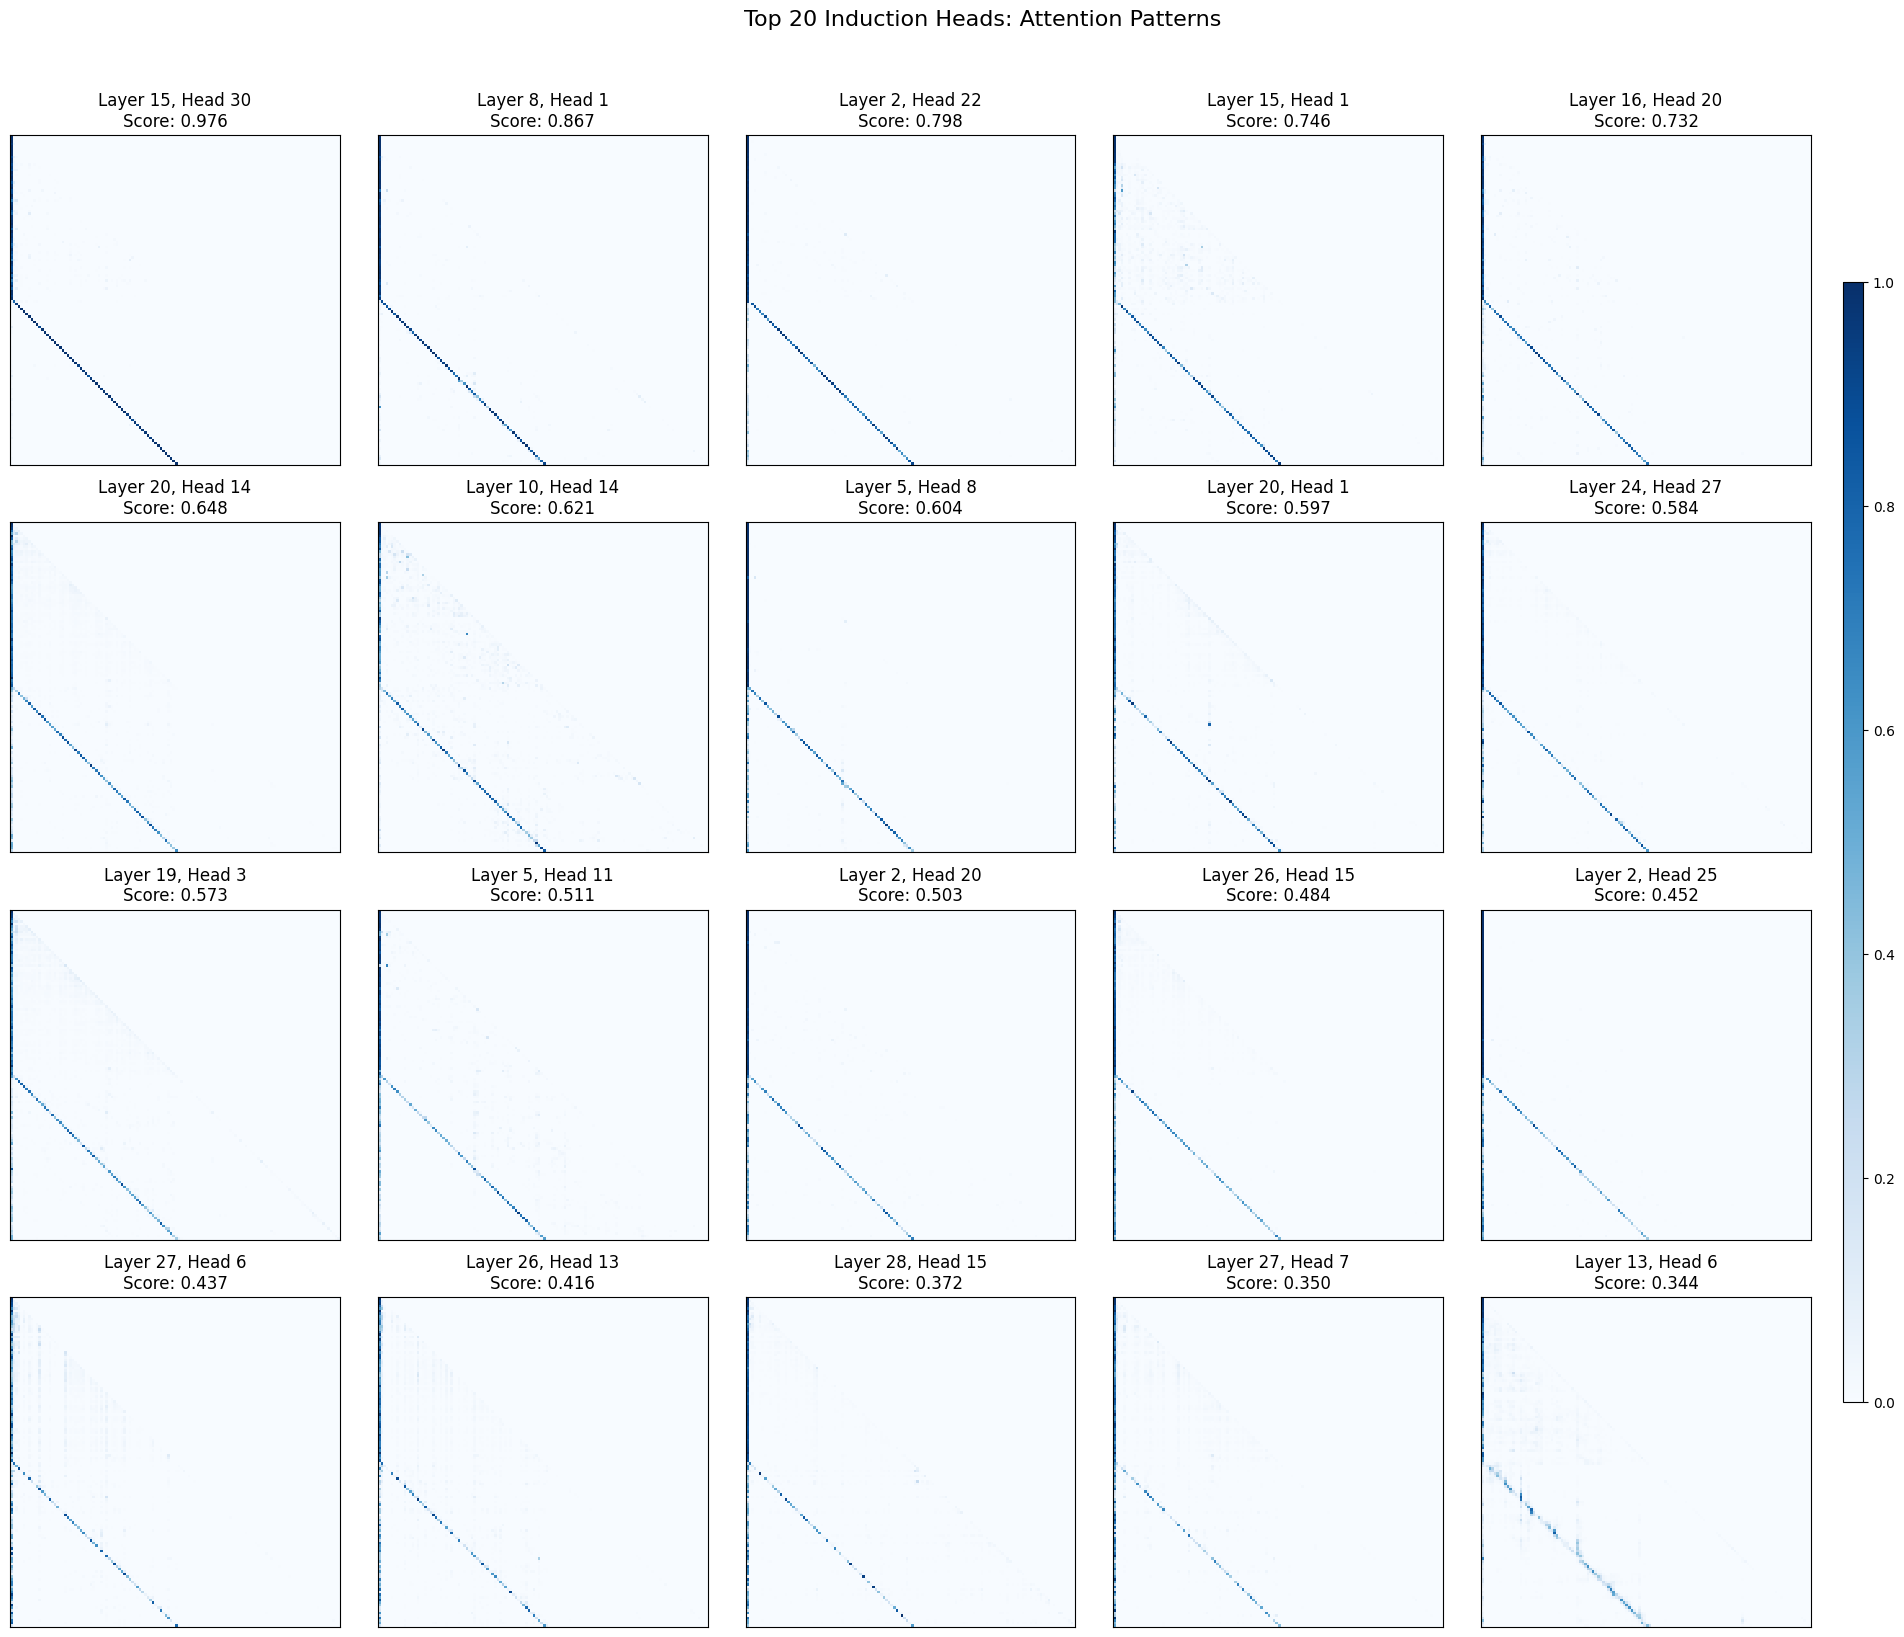

In [113]:
# Create a 4x5 grid of subplots for top 20 heads
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle("Top 20 Induction Heads: Attention Patterns", fontsize=16, y=1.02)

# Plot each attention pattern
for idx, (score, layer, head) in enumerate(induction_scores_as_list[:20]):
    row = idx // 5
    col = idx % 5
    
    pattern = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
    
    # Plot attention pattern
    im = axes[row, col].imshow(
        pattern.cpu(),
        cmap='Blues',
        interpolation='nearest'
    )
    
    # Add title with layer, head, and score information
    axes[row, col].set_title(f'Layer {layer}, Head {head}\nScore: {score:.3f}')
    
    # Remove ticks for cleaner look
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Add a colorbar that applies to all subplots
plt.tight_layout()
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [114]:
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

def activation_ablation_hook(
    activation: Float[Tensor, "batch seq d_activation"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_activation"]:
    activation[:, :, :] = torch.zeros_like(activation[:, :, :])
    return activation

def head_ablation_hook(
    activation: Float[Tensor, "batch seq n_heads d_activation"],
    hook: HookPoint,
    head: int,
) -> Float[Tensor, "batch seq n_heads d_activation"]:
    activation[:, :, head, :] = torch.zeros_like(activation[:, :, head, :])
    return activation

In [115]:
def get_repeated_token_loss(repeated_tokens: Int[Tensor, "batch seq"], logits: Float[Tensor, "batch seq d_vocab"]) -> Float[Tensor, "batch"]:
    log_probs = torch.log_softmax(logits, dim=-1).to(repeated_tokens.device)
    loss_per_token = torch.gather(input=-log_probs[0, :-1, :], dim=-1, index=repeated_tokens[1:].unsqueeze(-1))
    return loss_per_token.flatten()[log_probs.shape[1]//2:].mean()

In [121]:
import functools
from transformer_lens import utils

activation_type = "z"

patching_metrics = []
for n_heads_to_ablate in range(0, 50):
    heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]

    fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]
    logits = model.run_with_hooks(random_tokens_repeated, fwd_hooks=fwd_hooks)
    metric = get_repeated_token_loss(random_tokens_repeated, logits)
    patching_metrics.append(metric)

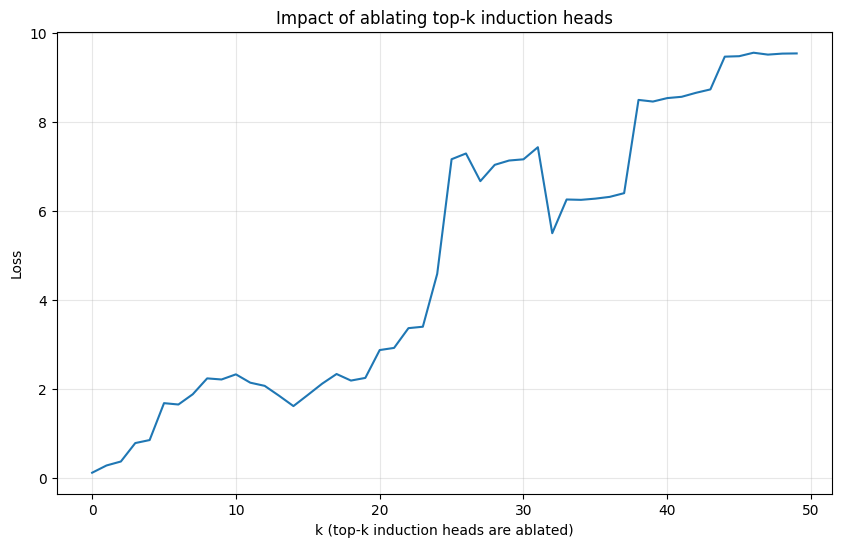

In [122]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(patching_metrics)
plt.xlabel('k (top-k induction heads are ablated)')
plt.ylabel('Loss')
plt.title('Impact of ablating top-k induction heads')
plt.grid(True, alpha=0.3)
plt.show()

## Grid task

In [123]:
grid = Grid(words, rows=4, cols=4)

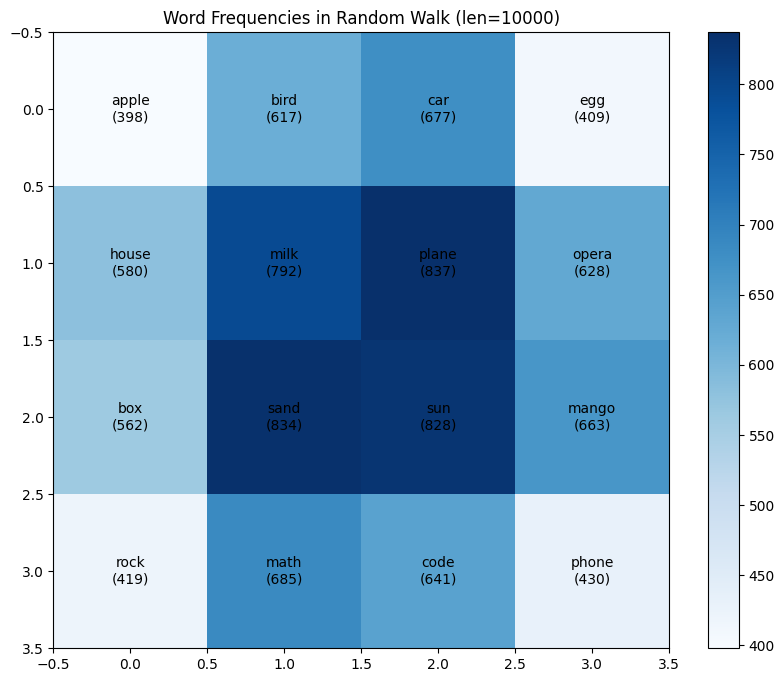

In [124]:
N_STEPS = 10_000

sequence = grid.generate_sequence(N_STEPS)

# histogram of word frequencies:
word_freq = {}
for word in sequence:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# Create a 2D array of frequencies matching the grid layout
freq_grid = np.zeros((grid.rows, grid.cols))
for i, row in enumerate(grid.grid):
    for j, word in enumerate(row):
        freq_grid[i][j] = word_freq.get(word, 0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(freq_grid, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Add word labels to each cell
for i in range(grid.rows):
    for j in range(grid.cols):
        plt.text(j, i, f'{grid.grid[i][j]}\n({int(freq_grid[i][j])})', 
                ha='center', va='center')
        

plt.title(f'Word Frequencies in Random Walk (len={N_STEPS})')
plt.show()


In [125]:
def tokenize_sequence(sequence: list[str]) -> torch.Tensor:
    sequence_as_string = ' ' + ' '.join(sequence)
    return model.tokenizer(sequence_as_string, return_tensors='pt').input_ids

In [126]:
sequence = grid.generate_sequence(10)

tokens = tokenize_sequence(sequence)
model.to_str_tokens(tokens)

['<|begin_of_text|>',
 ' box',
 ' house',
 ' box',
 ' house',
 ' milk',
 ' sand',
 ' box',
 ' house',
 ' apple',
 ' bird']

## Check impact of ablating induction heads on grid task performance

In [129]:
def get_model_accuracies(sequence: list[str], fwd_hooks: list[tuple[str, Callable]] = []):
    tokens = tokenize_sequence(sequence)
    logits = model.run_with_hooks(tokens.to(model.cfg.device), fwd_hooks=fwd_hooks)
    probs = torch.softmax(logits, dim=-1)
    probs = probs[0, 1:, :] # shave off bos token

    accuracies = []

    for i in range(len(sequence)):
        valid_next_words = grid.get_valid_next_words(sequence[i])
        valid_next_word_token_ids = torch.tensor([model.tokenizer.encode(' ' + w, add_special_tokens=False) for w in valid_next_words]).squeeze()
        accuracy = probs[i, valid_next_word_token_ids].sum().item()
        accuracies.append(accuracy)

    return accuracies

In [137]:
SEQ_LEN = 1400
ITERS = 20
SEED = 0

set_seed(SEED)
accuracies = []

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN)))

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [138]:
accuracies_top_1_ablated = []
n_heads_to_ablate = 1
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies_top_1_ablated.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [139]:
accuracies_top_3_ablated = []
n_heads_to_ablate = 3
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies_top_3_ablated.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


In [140]:
accuracies_top_5_ablated = []
n_heads_to_ablate = 5
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies_top_5_ablated.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [141]:
accuracies_top_10_ablated = []
n_heads_to_ablate = 10
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies_top_10_ablated.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


In [142]:
accuracies_top_20_ablated = []
n_heads_to_ablate = 20
heads_to_ablate = [(layer, head) for _, layer, head in induction_scores_as_list[:n_heads_to_ablate]]
fwd_hooks = [(utils.get_act_name(activation_type, layer), functools.partial(head_ablation_hook, head=head)) for layer, head in heads_to_ablate]

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies_top_20_ablated.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN), fwd_hooks=fwd_hooks))

100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


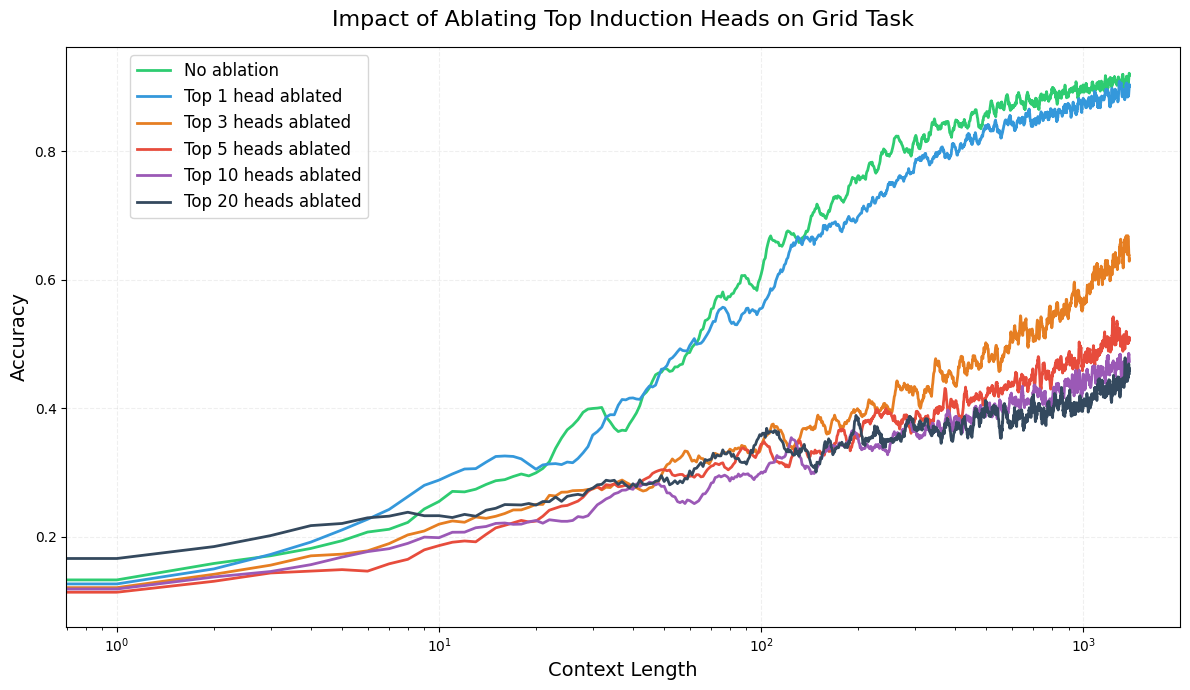

In [151]:
plt.figure(figsize=(12, 7))

# Convert all accuracies to numpy arrays and get means
mean_normal = np.array(accuracies).mean(axis=0)
mean_top1 = np.array(accuracies_top_1_ablated).mean(axis=0)
mean_top3 = np.array(accuracies_top_3_ablated).mean(axis=0)
mean_top5 = np.array(accuracies_top_5_ablated).mean(axis=0)
mean_top10 = np.array(accuracies_top_10_ablated).mean(axis=0)
mean_top20 = np.array(accuracies_top_20_ablated).mean(axis=0)

# Apply some smoothing to make lines clearer
window = 10
def smooth(x): return np.convolve(x, np.ones(window)/window, mode='valid')

# Plot lines with distinct colors and thicker lines
plt.plot(smooth(mean_normal), label='No ablation', color='#2ecc71', linewidth=2)  # Green
plt.plot(smooth(mean_top1), label='Top 1 head ablated', color='#3498db', linewidth=2)  # Blue
plt.plot(smooth(mean_top3), label='Top 3 heads ablated', color='#e67e22', linewidth=2)  # Orange
plt.plot(smooth(mean_top5), label='Top 5 heads ablated', color='#e74c3c', linewidth=2)  # Red
plt.plot(smooth(mean_top10), label='Top 10 heads ablated', color='#9b59b6', linewidth=2)  # Purple
plt.plot(smooth(mean_top20), label='Top 20 heads ablated', color='#34495e', linewidth=2)  # Dark Gray

plt.xscale('log')
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Impact of Ablating Top Induction Heads on Grid Task', fontsize=16, pad=15)

# Customize grid
plt.grid(True, alpha=0.2, linestyle='--')

# Move legend outside
plt.legend(fontsize=12, bbox_to_anchor=(0.05, 1), loc='upper left')

# Add some padding to prevent label cutoff
plt.tight_layout()
plt.show()